<a href="https://colab.research.google.com/github/etorresram/Sample_Code_Job_Postings_Analytics/blob/main/job_postings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analysis of Job Postings on Google Careers for Argentina**:

This database contains a list of job vacancies in Argentina that were collected daily from the Google Careers platform through web scraping, from January 2023 to July 2023.


In [160]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set_theme()

## **Loading the data**

In [161]:
df = pd.read_parquet('/content/arg_vacancies.parquet')
df_arg=df_arg[['date_posted','firm','place', 'descrip', 'source', 'city', 'zones']]
df_arg.columns.to_list()

['date_posted', 'firm', 'place', 'descrip', 'source', 'city', 'zones']

## **List of variables**
**'date_posted'**: Date on which the job vacancy was posted.<br>
**'firm'**: Company posting the job vacancy.<br>
**'descrip'**: Full description of the job vacancy.<br>
**'source'**: Platform where the job vacancy was originally posted.<br>
**'city'**: Location where the job is required.<br>
**'zones'**: Level of knowledge and experience required for the position.<br>

# **Trends of job postings**

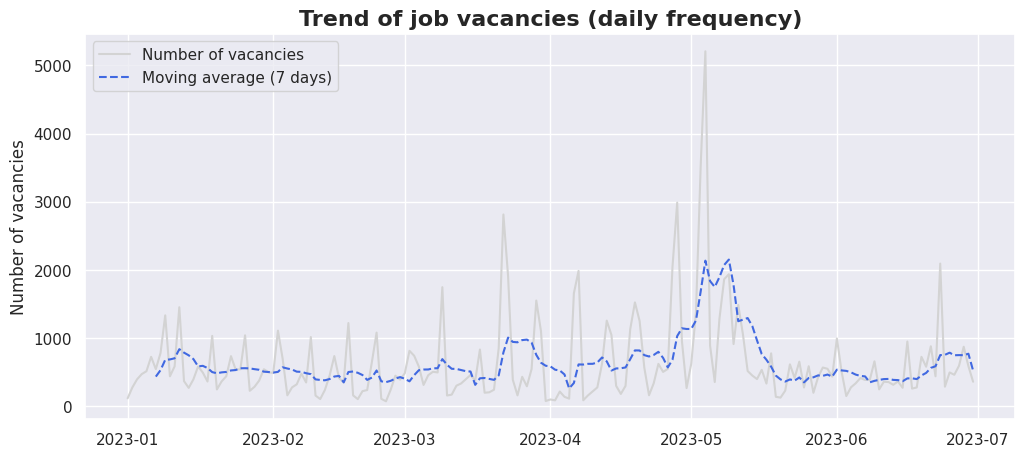

In [162]:
df_arg['date_posted'] = pd.to_datetime(df_arg['date_posted'])

date_counts = df_arg['date_posted'].value_counts().reset_index()
date_counts.columns = ['Date', 'Number of vacancies']
date_counts = date_counts.sort_values('Date')
date_counts['Moving average'] = date_counts['Number of vacancies'].rolling(window=7).mean()

plt.figure(figsize=(12, 5))
plt.plot(date_counts['Date'], date_counts['Number of vacancies'], marker='', linestyle='-', color='lightgrey', label='Number of vacancies')
plt.plot(date_counts['Date'], date_counts['Moving average'], linestyle='--', color='royalblue', label='Moving average (7 days)')
plt.title('Trend of job vacancies (daily frequency)', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('Number of vacancies')
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

# **Job postings by city**

In [163]:
city_counts = df_arg["city"].value_counts().reset_index()
city_counts.columns = ['city', 'counts']

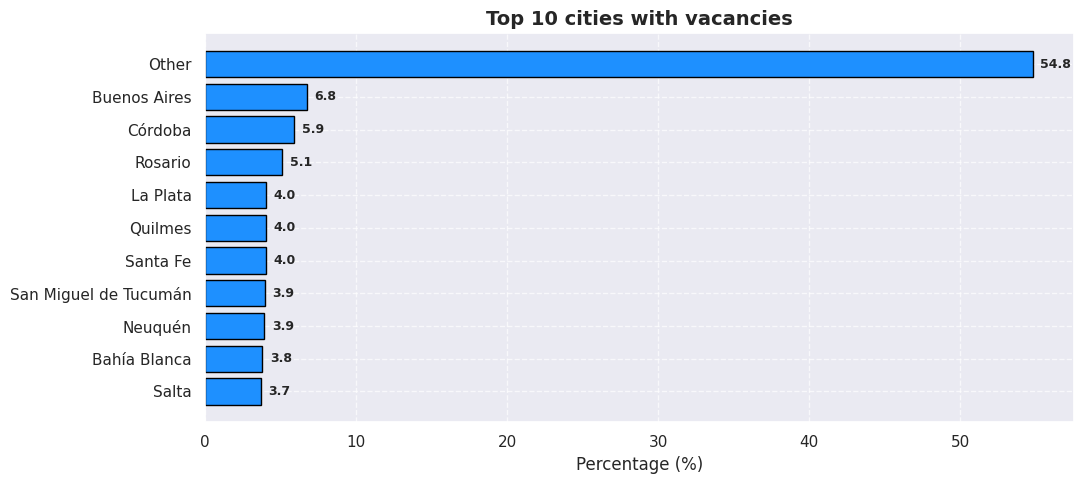

In [164]:
city_counts['percentage'] = (city_counts['counts'] / city_counts['counts'].sum()) * 100

top_10 = city_counts.sort_values(by='percentage', ascending=False).head(10)
other = pd.DataFrame({
    'city': ['Other'],
    'counts': city_counts.iloc[10:]['counts'].sum(),
    'percentage': city_counts.iloc[10:]['percentage'].sum()
})

final_counts = pd.concat([top_10, other], ignore_index=True).sort_values(by='percentage', ascending=True)

plt.figure(figsize=(11, 5))
bars = plt.barh(final_counts['city'], final_counts['percentage'], color='dodgerblue', edgecolor='black')

for bar, pct in zip(bars, final_counts['percentage']):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{pct:.1f}',
        va='center',
        fontsize=9,
        fontweight='bold'
    )

plt.title('Top 10 cities with vacancies', fontsize=14, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **Required qualifications**

In [165]:
df_arg['zones'] = df_arg['zones'].replace(zone_labels := {
    1: 'Low or no qualification',
    2: 'Some qualification',
    3: 'Medium qualification',
    4: 'High qualification',
    5: 'Expert-level qualification'
})

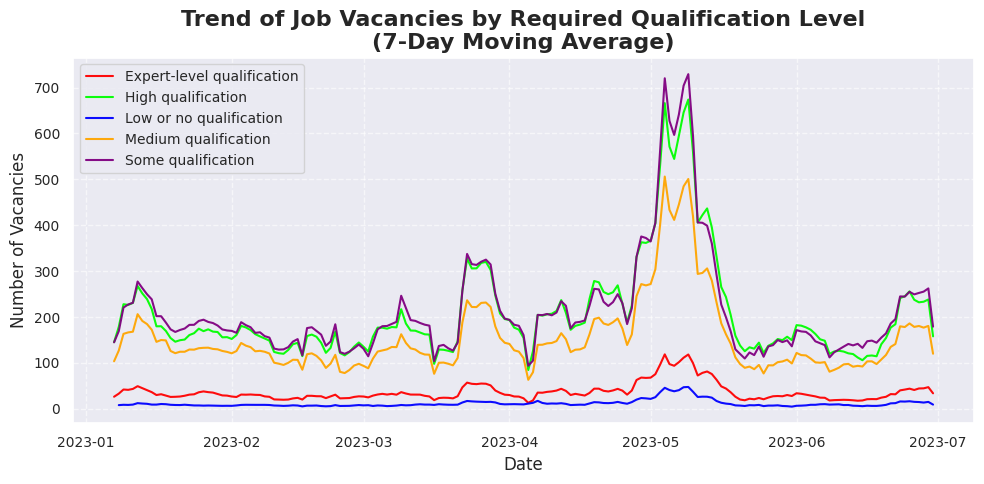

In [167]:
vivid_colors = [
    '#FF0000', '#00FF00', '#0000FF', '#FFA500', '#800080',
    '#00FFFF', '#FFD700', '#FF1493', '#00FF7F', '#1E90FF' ]


plt.figure(figsize=(10, 5))

for (area, data), color in zip(filtered_counts.groupby('zones'), vivid_colors):
    plt.plot(
        data['date_posted'],
        data['media_movil'],
        label=zone_labels.get(area, area),
        linewidth=1.5,
        alpha=0.95,
        color=color
    )

plt.title('Trend of Job Vacancies by Required Qualification Level\n(7-Day Moving Average)', fontsize=16, fontweight='bold')
plt.ylabel('Number of Vacancies', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()

# **Telework identification**

In [168]:
import re

# Telework keywords
keywords = [
    'teletrabajo', 'trabajo remoto', 'modalidad mixta', 'home office',
    'trabajo a distancia', 'trabajo en casa', 'trabajo virtual',
    'trabajo híbrido', 'híbrida', 'híbrido', 'trabajo desde el hogar'
]

def normalize_keyword(keyword):
    return (
        keyword.lower()
        .replace('á', '[aá]')
        .replace('é', '[eé]')
        .replace('í', '[ií]')
        .replace('ó', '[oó]')
        .replace('ú', '[uú]')
    )

pattern = '|'.join([normalize_keyword(kw) for kw in keywords])

df_arg['telework'] = df_arg['descrip'].str.lower().str.contains(pattern, regex=True, na=False).astype(int)
df_arg['telework'].value_counts()

,count
telework,
0,111445
1,4577


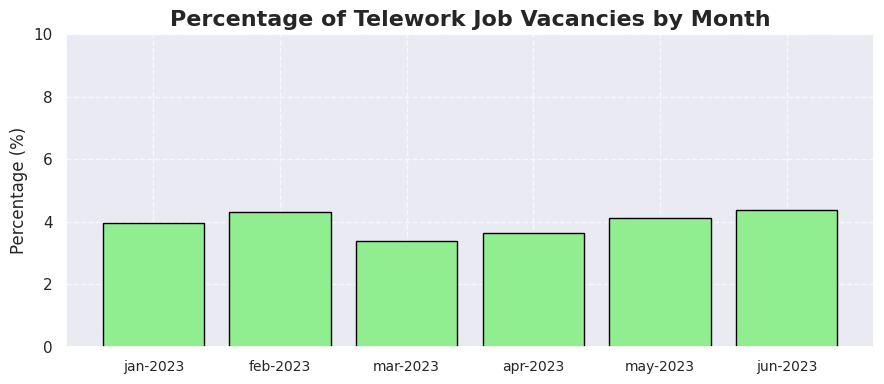

In [178]:
df_arg['date_posted'] = pd.to_datetime(df_arg['date_posted'])
df_arg['year_month'] = df_arg['date_posted'].dt.strftime('%b-%Y').str.lower()

monthly_telework = (
    df_arg.groupby('year_month')['telework']
    .agg(['sum', 'count'])
    .assign(percentage=lambda x: (x['sum'] / x['count']) * 100)
    .reset_index()
)

monthly_telework['date_order'] = pd.to_datetime(monthly_telework['year_month'], format='%b-%Y')
monthly_telework = monthly_telework.sort_values(by='date_order')

plt.figure(figsize=(9, 4))
plt.bar(
    monthly_telework['year_month'],
    monthly_telework['percentage'],
    color='lightgreen',
    edgecolor='black'
)

plt.title('Percentage of Telework Job Vacancies by Month', fontsize=16, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12)
plt.ylim(0, 10)
plt.xticks(rotation=0, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# **Platforms**
Google Careers collects job vacancies from various platforms.

In [175]:
# Here we correct the names to prevent category duplication
df_arg['source'] = df_arg['source'].replace({
    'a través de Sercanto': 'Sercanto',
    'via Sercanto': 'Sercanto',
    'a través de BeBee': 'BeBee',
    'via BeBee': 'BeBee',
    'a través de LinkedIn': 'LinkedIn',
    'a través de via LinkedIn': 'LinkedIn',
    'a través de Bumeran': 'Bumeran',
    'a través de Computrabajo': 'Computrabajo',
    'a través de Trabajo.org': 'Trabajo.org',
    'a través de Jobrapido.com': 'Jobrapido.com',
    'a través de Universia': 'Universia',
    'a través de Kit Empleo': 'Kit Empleo',
    'a través de Glassdoor': 'Glassdoor',
    'a través de Indeed Argentina': 'Indeed Argentina',
    'a través de Computrabajo Argentina': 'Computrabajo',
    'a través de Trabajo.org - Vacantes De Empleo, Trabajo': 'Trabajo.org',
    'a través de Randstad': 'Randstad',
})

In [176]:
source_counts = df_arg["source"].value_counts().reset_index()
source_counts.columns = ['source', 'counts']


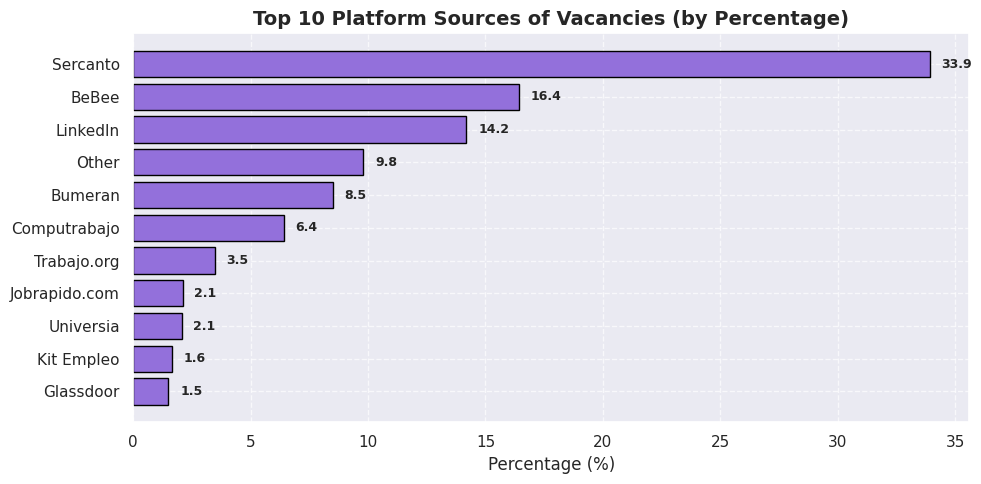

In [177]:
source_counts['percentage'] = (source_counts['counts'] / source_counts['counts'].sum()) * 100

top_10 = source_counts.sort_values(by='percentage', ascending=False).head(10)
other = pd.DataFrame({
    'source': ['Other'],
    'counts': source_counts.iloc[10:]['counts'].sum(),
    'percentage': source_counts.iloc[10:]['percentage'].sum()
})

final_counts = pd.concat([top_10, other], ignore_index=True).sort_values(by='percentage', ascending=True)

plt.figure(figsize=(10, 5))
bars = plt.barh(final_counts['source'], final_counts['percentage'], color='mediumpurple', edgecolor='black')

for bar, pct in zip(bars, final_counts['percentage']):
    plt.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f'{pct:.1f}',
        va='center',
        fontsize=9,
        fontweight='bold'
    )

plt.title('Top 10 Platform Sources of Vacancies (by Percentage)', fontsize=14, fontweight='bold')
plt.xlabel('Percentage (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()